In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import os
import sys
import re
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
import s3fs

/Users/ldoddi/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utils import process_tweet

In [4]:
data = pd.read_csv("s3://twitter-sentiment-laks/processed/sentiment_label_data.csv")
data.sample(5)

,Unnamed: 0,sentiment,text
835770,578347,0,At werk!! Can't wait for the hubby to pick me ...
702377,1555411,1,@chidread no prob...
626330,40030,0,"@mariashriver I once sent you a letter, about ..."
425985,1544262,1,@arsenal_fann What are you talking about?! Tha...
848459,276129,0,Is it national drop your dog off on the highwa...


In [5]:
data.shape

(1000000, 3)

In [23]:
data["tweets"] = data["text"].map(lambda x : process_tweet(x))

In [24]:
#Added column clean_tweet to store te processed tweets 
data["tweets"].sample(10)

941298    mmmm, iced coffee... - …that i still need to f...
729592    @sunkitty7 season 2 - amazing wonderful! and t...
334193    feeling very sad after an emotional day ... mo...
834332    im extremely disappointed with the mikey show....
637117                             @analovestito  clean me!
678544                                    i'm so bored now 
594591    in the words of imogen heap........... is that...
132428                        sorry deejj they're gone  lol
171964    assassins creed 2 trailer was awesome. no i am...
648623    @mvanduyne http://twitpic.com/7t1b9 - yeha, i ...
Name: tweets, dtype: object

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['tweets'], data['sentiment'], test_size = 0.333, random_state=0)

In [26]:
X_train[0]

'actually loves her life right now '

In [27]:
y_train[0]

1

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_train)


In [30]:
#vect.get_feature_names()[::10]

In [31]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized.get_shape()

(667000, 378164)

In [32]:
logistic_regression = linear_model.LogisticRegression(solver='liblinear')

In [33]:
logistic_regression.fit(X_train_vectorized, y_train)


LogisticRegression(solver='liblinear')

In [34]:
X_test_vectorized = vect.transform(X_test)
X_test_vectorized.get_shape()

(333000, 378164)

In [35]:
predicted_labels = logistic_regression.predict(X_test_vectorized)

In [37]:
from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score (y_test, predicted_labels))

AUC: 0.796709526336246


In [38]:
predicted_labels[:5]

array([1, 1, 0, 1, 0])

In [39]:
# Confusion Matrix to evaluate for binary classification
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predicted_labels)
#confusion_matrix = confusion_matrix.astype(int)
print(confusion_matrix)

[[130757  35839]
 [ 31859 134545]]


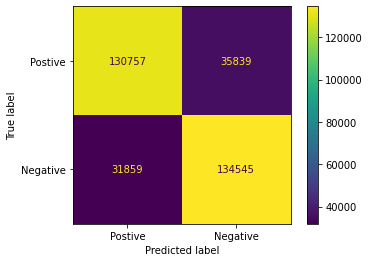

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Postive', 'Negative'])
disp.ax.set_title("Logistics Regression")
disp.plot()

In [48]:
#Calculating precision, recall, f1_score 
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
print('Precision    : %.3f'%precision_score(y_test, predicted_labels))
print('Recall       : %.3f'%recall_score(y_test, predicted_labels))
print('F1 Score     : %.3f'%f1_score(y_test, predicted_labels))

Precision    : 0.790
Recall       : 0.809
F1 Score     : 0.799


In [76]:
#model_dir = 's3://twitter-sentiment-laks/trained_models/'
model_dir='trained_models/'
file_name='s3://twitter-sentiment-laks/trained_models/logistics_regression.sav'
fs = s3fs.S3FileSystem(anon=False)
pickle.dump(logistic_regression, fs.open(file_name, 'wb'))
print('Process Completed')

s3://twitter-sentiment-laks/trained_models/logistics_regression.sav
